In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/home/grads/s/sheelabhadra/Projects/Pi-star-Skyblazers-DSC-2020/env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import pandas as pd
import numpy as np

In [4]:
df_raw = pd.read_pickle('../data/flight_delays.pkl')

In [5]:
df_raw['DEP_TIME_HR'] = df_raw['DEP_TIME'].apply(lambda x: x//100 if x != -9999 else -9999)
df_raw['DEP_TIME_MIN'] = df_raw['DEP_TIME'].apply(lambda x: x%10 if x != -9999 else -9999)
df_raw['ARR_TIME_HR'] = df_raw['ARR_TIME'].apply(lambda x: x//100 if x != -9999 else -9999)
df_raw['ARR_TIME_MIN'] = df_raw['ARR_TIME'].apply(lambda x: x%100 if x != -9999 else -9999)
df_raw['CRS_DEP_TIME_HR'] = df_raw['CRS_DEP_TIME'].apply(lambda x: x//100 if x != -9999 else -9999)
df_raw['CRS_DEP_TIME_MIN'] = df_raw['CRS_DEP_TIME'].apply(lambda x: x%100 if x != -9999 else -9999)
df_raw['CRS_ARR_TIME_HR'] = df_raw['CRS_ARR_TIME'].apply(lambda x: x//100 if x != -9999 else -9999)
df_raw['CRS_ARR_TIME_MIN'] = df_raw['CRS_ARR_TIME'].apply(lambda x: x%100 if x != -9999 else -9999)

In [6]:
df_raw.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 'DEST_CITY',
       'DEST_STATE', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
       'ARR_TIME_BLK', 'CANCELED', 'CANCELLATION_CODE', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'PASSENGERS', 'EMPFULL', 'EMPPART', 'EMPTOTAL',
       'EMPFTE', 'NET_INCOME', 'OP_REVENUES', 'DEP_TIME_HR', 'DEP_TIME_MIN',
       'ARR_TIME_HR', 'ARR_TIME_MIN', 'CRS_DEP_TIME_HR', 'CRS_DEP_TIME_MIN',
       'CRS_ARR_TIME_HR', 'CRS_ARR_TIME_MIN'],
      dtype='object')

In [7]:
cols_to_keep = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'PASSENGERS', 'EMPFULL', 'EMPPART', 'EMPTOTAL',
       'EMPFTE', 'NET_INCOME', 'OP_REVENUES', 'DEP_TIME_HR', 'DEP_TIME_MIN',
       'ARR_TIME_HR', 'ARR_TIME_MIN', 'CRS_DEP_TIME_HR', 'CRS_DEP_TIME_MIN',
       'CRS_ARR_TIME_HR', 'CRS_ARR_TIME_MIN']

In [8]:
df_trim = df_raw[cols_to_keep]
del df_raw

In [9]:
def replace_with_nan(df, element, cols):
    for col in cols:
        df[col].replace(element, np.nan, inplace=True)

In [10]:
replace_with_nan(df_trim, -9999, df_trim.columns)

In [11]:
# Consider delays that are only less than 60 mins
df_trim = df_trim[df_trim['DEP_DELAY_NEW'] < 60]
df_trim.reset_index(drop=True, inplace=True)

In [12]:
print(df_trim.shape)

(10007760, 38)


## Feature Engineering

In [13]:
# 1. Aggregate number of flights by origin, and dep_time_blk
res = df_trim.groupby(['ORIGIN', 'DEP_TIME_BLK']).agg({'DEP_DELAY_NEW': 'count'}).reset_index().rename(columns={'DEP_DELAY_NEW': 'FLIGHTS_ORIGIN'})

In [14]:
df_trim = pd.merge(df_trim, res, on=['ORIGIN', 'DEP_TIME_BLK'], how='inner')

In [15]:
# 2. Aggregate number of passengers by origin and dep_time_blk
res = df_trim.groupby(['ORIGIN', 'DEP_TIME_BLK']).agg({'PASSENGERS': 'sum'}).reset_index().rename(columns={'PASSENGERS': 'PASSENGERS_ORIGIN'})
df_trim = pd.merge(df_trim, res, on=['ORIGIN', 'DEP_TIME_BLK'], how='inner')

In [16]:
# 3. Aggregate number of outgoing flights by origin, carrier, and dep_time_blk
res = df_trim.groupby(['ORIGIN', 'CARRIER','DEP_TIME_BLK']).agg({'DEP_DELAY_NEW': 'count'}).reset_index().rename(columns={'DEP_DELAY_NEW': 'FLIGHTS_OUT'})
df_trim = pd.merge(df_trim, res, on=['ORIGIN', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [17]:
# 4. Aggregate number of incoming flights by dest, carrier, and arr_time_blk
res = df_trim.groupby(['DEST', 'CARRIER','ARR_TIME_BLK']).agg({'DEP_DELAY_NEW': 'count'}).reset_index().rename(columns={'DEP_DELAY_NEW': 'FLIGHTS_IN'})
df_trim = pd.merge(df_trim, res, on=['DEST', 'CARRIER', 'ARR_TIME_BLK'], how='inner')

In [18]:
df_trim.head().T

,0,1,2,3,4
YEAR,2018,2018,2018,2018,2018
QUARTER,1,1,1,1,1
MONTH,1,1,1,1,1
DAY_OF_MONTH,1,1,2,3,4
DAY_OF_WEEK,1,1,2,3,4
FL_DATE,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00
CARRIER,9E,9E,9E,9E,9E
FL_NUM,3331,3361,3361,3293,3293
ROUTE,42,63,63,63,63
ORIGIN,ABY,AEX,AEX,AEX,AEX


In [19]:
def read_column_types(excel_file_path):
    df = pd.read_excel(excel_file_path)
    category_cols, numeric_cols, date_cols = [], [], []
    for _, row in df.iterrows():
        if row['TYPE'] == 'Nominal' or row['TYPE'] == 'Ordinal' or row['TYPE'] == 'Binary':
            category_cols.append(row['ATTRIBUTE'])
        if row['TYPE'] == 'Interval':
            numeric_cols.append(row['ATTRIBUTE'])
        if row['TYPE'] == 'yyyymmdd':
            date_cols.append(row['ATTRIBUTE'])
    return category_cols, numeric_cols, date_cols

def add_column_names(category_cols, numeric_cols, date_cols, cols, col_type="Category"):
    if col_type == "Category":
        category_cols.extend(cols)
    if col_type == "Numeric":
        numeric_cols.extend(cols)
    if col_type == "Datetime":
        date_cols.extend(cols)
    return category_cols, numeric_cols, date_cols

def convert_to_categorical(df, cols):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        df[col].astype('category', inplace=True)

In [20]:
c, n, d = read_column_types('../data/FlightDataDescription.xlsx')
c, n, d = add_column_names(c, n, d, cols=['CARRIER'], col_type="Category")

In [21]:
df_trim.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'ARR_TIME_BLK',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY',
       'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'PASSENGERS',
       'EMPFULL', 'EMPPART', 'EMPTOTAL', 'EMPFTE', 'NET_INCOME', 'OP_REVENUES',
       'DEP_TIME_HR', 'DEP_TIME_MIN', 'ARR_TIME_HR', 'ARR_TIME_MIN',
       'CRS_DEP_TIME_HR', 'CRS_DEP_TIME_MIN', 'CRS_ARR_TIME_HR',
       'CRS_ARR_TIME_MIN', 'FLIGHTS_ORIGIN', 'PASSENGERS_ORIGIN',
       'FLIGHTS_OUT', 'FLIGHTS_IN'],
      dtype='object')

In [22]:
c = ['YEAR', 'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 'DEP_DEL15', 'DEP_DELAY_GROUP', 
     'DEP_TIME_BLK', 'ARR_TIME_BLK']

In [23]:
convert_to_categorical(df_trim, c)

In [24]:
def convert_to_integer(df, cols):
    for col in cols:
        df[col] = df[col].round().astype('int64')

In [25]:
# convert_to_integer(df_raw, n + ['DEP_TIME_HR', 'DEP_TIME_MIN',
#        'ARR_TIME_HR', 'ARR_TIME_MIN', 'CRS_DEP_TIME_HR', 'CRS_DEP_TIME_MIN',
#        'CRS_ARR_TIME_HR', 'CRS_ARR_TIME_MIN'])

In [26]:
cols_to_keep = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 
       'CRS_DEP_TIME_HR', 'CRS_ARR_TIME_HR', 'CRS_ELAPSED_TIME', 'CRS_DEP_TIME_MIN', 'CRS_ARR_TIME_MIN',
       'ARR_TIME_BLK', 'DEP_TIME_BLK',
       'DISTANCE', 'PASSENGERS', 'EMPFULL', 'EMPPART', 'EMPTOTAL',
       'EMPFTE', 'NET_INCOME', 'OP_REVENUES', 'FLIGHTS_ORIGIN', 'PASSENGERS_ORIGIN',
       'FLIGHTS_OUT', 'FLIGHTS_IN',
       'DEP_DELAY_NEW']

In [35]:
df, y, nas = proc_df(df_trim[cols_to_keep], 'DEP_DELAY_NEW')

In [36]:
df.head().T

,0,1,2,3,4
YEAR,1,1,1,1,1
QUARTER,1,1,1,1,1
MONTH,1,1,1,1,1
DAY_OF_MONTH,1,1,2,3,4
DAY_OF_WEEK,1,1,2,3,4
CARRIER,1,1,1,1,1
FL_NUM,3329,3359,3359,3291,3291
ROUTE,41,62,62,62,62
ORIGIN,5,12,12,12,12
DEST,22,22,22,22,22


In [37]:
df.dtypes

YEAR                      int8
QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
CARRIER                   int8
FL_NUM                   int16
ROUTE                    int16
ORIGIN                   int16
DEST                     int16
CRS_DEP_TIME_HR          int64
CRS_ARR_TIME_HR          int64
CRS_ELAPSED_TIME       float64
CRS_DEP_TIME_MIN         int64
CRS_ARR_TIME_MIN         int64
ARR_TIME_BLK              int8
DEP_TIME_BLK              int8
DISTANCE                 int16
PASSENGERS             float64
EMPFULL                float64
EMPPART                float64
EMPTOTAL               float64
EMPFTE                 float64
NET_INCOME             float64
OP_REVENUES            float64
FLIGHTS_ORIGIN           int64
PASSENGERS_ORIGIN      float64
FLIGHTS_OUT              int64
FLIGHTS_IN               int64
CRS_ELAPSED_TIME_na       bool
PASSENGERS_na             bool
EMPFULL_na                bool
EMPPART_

In [38]:
y = np.array(y)

In [39]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='median')
y = imp.fit_transform(y.reshape(-1,1))

## Final model

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
n_samples = 1000000
df_test, y_test = df.loc[:n_samples-1], y[:n_samples]

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(df_test, y_test, test_size=0.05, random_state=0) 

In [53]:
print(X_train.shape, X_valid.shape)

(950000, 37) (50000, 37)


## Confidence based on tree variance

In [54]:
# set_rf_samples(100000)

In [55]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, max_features=0.5)
%time m.fit(X_train, y_train)

/home/grads/s/sheelabhadra/Projects/Pi-star-Skyblazers-DSC-2020/env/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CPU times: user 8min 32s, sys: 908 ms, total: 8min 32s
Wall time: 37.8 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [56]:
from sklearn.metrics import mean_squared_error

In [57]:
res = [math.sqrt(mean_squared_error(m.predict(X_train), y_train)), math.sqrt(mean_squared_error(m.predict(X_valid), y_valid)),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
print(res)

[8.144029283589028, 11.36926797992311, 0.5249387264928086, 0.07589632785970023]


In [58]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 748 ms, sys: 908 ms, total: 1.66 s
Wall time: 2.3 s


(1.4462301587301587, 1.8982774378474196)

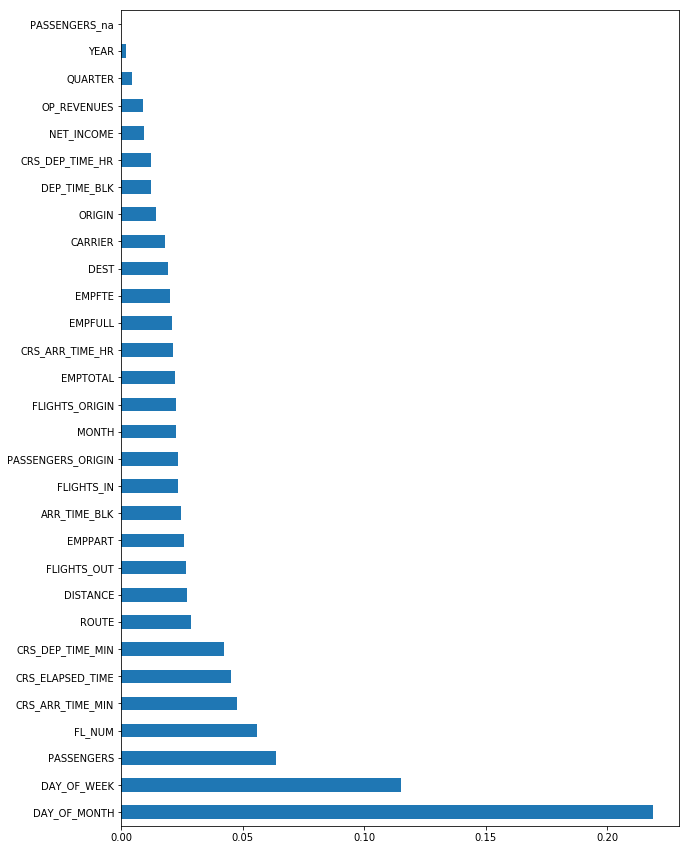

In [59]:
feat_importances = pd.Series(m.feature_importances_, index=df.columns)
plt.figure(figsize=(10,15))
feat_importances.nlargest(30).plot(kind='barh')

## Removing redundant features

In [71]:
from scipy.cluster import hierarchy as hc
from scipy.spatial.distance import squareform

In [78]:
#corr = np.round(scipy.stats.spearmanr(df_test).correlation, 4)
#corr_condensed = squareform(1-corr)
#z = hc.linkage(corr_condensed, method='average')
#fig = plt.figure(figsize=(16,10))
#dendrogram = hc.dendrogram(z, labels=df_test.columns, orientation='left', leaf_font_size=16)
#plt.show()

## Partial Dependence

In [80]:
from pdpbox import pdp
from plotnine import *

In [113]:
x_all = get_sample(df_trim, 10000)

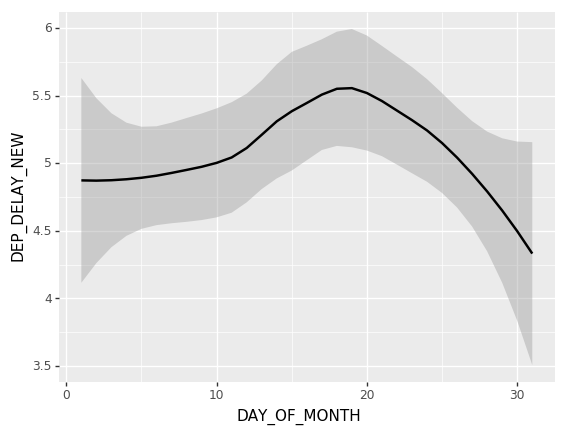

<ggplot: (8736553578581)>

In [116]:
ggplot(x_all, aes('DAY_OF_MONTH', 'DEP_DELAY_NEW'))+stat_smooth(se=True, method='loess')

In [128]:
x = get_sample(X_train, 1000)

In [129]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, df_test.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22301afe48>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2230180550>})

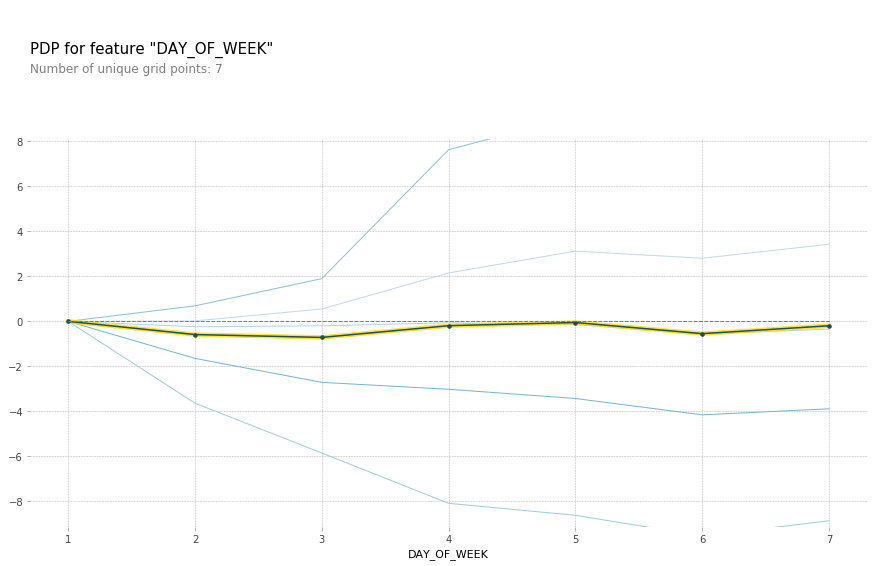

In [133]:
plot_pdp(feat='DAY_OF_WEEK', clusters=5)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22300f4240>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2230185be0>})

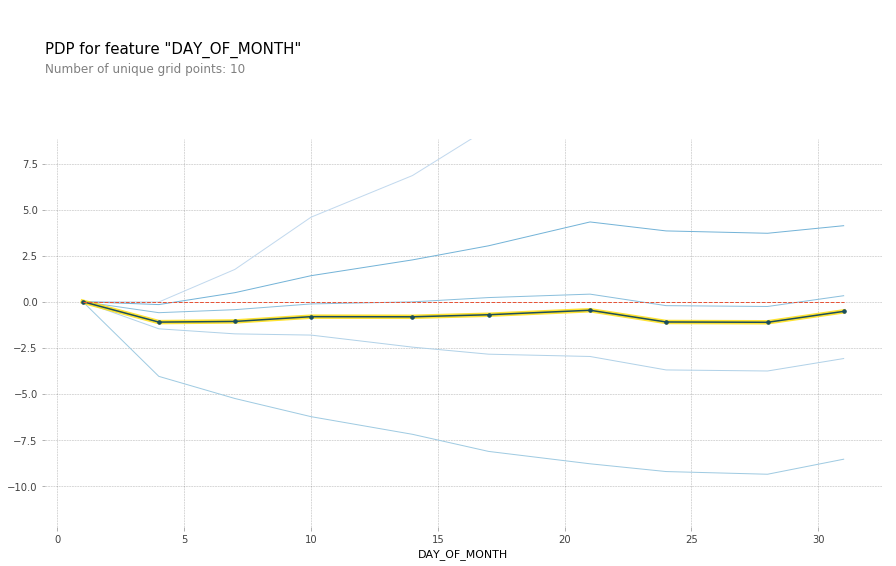

In [134]:
plot_pdp(feat='DAY_OF_MONTH', clusters=5)

## Tree Interpreter

In [137]:
from treeinterpreter import treeinterpreter as ti

## Select features

In [43]:
cols_to_keep = feat_importances[feat_importances > 0.03]

In [44]:
df_full = df[cols_to_keep.index]
df_dummy = df[:5]
del df
del df_trim
del df_test

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(df_full, y, test_size=0.05, random_state=42) 

In [46]:
print(X_train.shape, X_valid.shape)

(9507372, 7) (500388, 7)


In [47]:
del df_full
del y

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, max_features=0.5)
%time m.fit(X_train, y_train)

/home/grads/s/sheelabhadra/Projects/Pi-star-Skyblazers-DSC-2020/env/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [ ]:
res = [math.sqrt(mean_squared_error(m.predict(X_train), y_train)), math.sqrt(mean_squared_error(m.predict(X_valid), y_valid)),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
print(res)

In [ ]:
feat_importances = pd.Series(m.feature_importances_, index=df_dummy[cols_to_keep.index].columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
del X_train
del y_train
del X_valid
del y_valid